# Data Cleaning Strategy
For this project, we will use the CTN0027 Dataset from the clinical trial network.<br>
The dataset and all it's documentation are avaialble at the following website:<br>
https://datashare.nida.nih.gov/study/nida-ctn-0027<br>

There are a few challenges to highlight that should be considered in the cleaning approach:
- Large de-identified dataset must be manually labeled, very time consuming and prone to errors
- High dimension data - Requires bespoke transformations to fit into machine learning models

## Tables to be cleaned
| File Name | Table Name | Variable |Description | Process Applied |
| :--- | :--- | :--- | :--- | :--- |
| T_FRRSA.csv | Research Session Attendance|RSA |Records attendence for each week of treatment | Clean, Flatten, Feature Extraction, Merge |
| T_FRDEM.csv | Demographics|DEM |Gender | Clean, Merge |
| T_FRUDSAB.csv | Urine Drug Screen| UDS  |Drug test for 8 different drug classes, taken weekly for 24 weeks | Clean, Flatten, Feature Extraction, Merge |
| T_FRPEX.csv | Physical Exam|PEX |Tracks the appearance and condition of patients for 12 different physical observations| Clean, Merge |
| T_FRTFB.csv | Timeline Follow Back Survey|TFB |Surveys for self reported drug use, collected every 4 weeks, includes previous 30 days of use ot week 0, 4, 8, 12, 16, 20, 24| Clean, Aggregate, Flatten, Merge |
|T_FRDOS.csv | Dose Record |DOS |Records the medication, averge weekly dose and week of treatment| Clean, Aggregate, Feature Extraction, Flatten, Merge |
|T_FRCOWS.csv| Clinical Opiate Withdrawal Scale (Predose)|CW1 |Records the severity of opiate withdrawal symptoms, taken at assessment| Clean, Merge |
|T_FRCOWS2.csv| Clinical Opiate Withdrawal Scale (Postdose)|CW2 |Records the severity of opiate withdrawal symptoms, taken after dose| Clean, Merge |


## Data Cleaning Process
We will try to keep things simple and employ a process driven by reusable functions<br>
to **improve data quality**, **reducing errors**, **removing time consuming manual processes**, **improving efficiency**.<br>
<br> 
For each table we will follow the following steps:<br>
1. Load the data
2. Identify columns that require labels
3. Apply labels to columns
4. Drop columns that are not needed
5. Apply transformations to values where required
6. Feature Engineering (if necessary)
7. Flatten Dataframes (Reshape from deep to wide format)
8. Merge with other tables

## List of Reusable Functions
| Name of Function | Description | 
| ---------------- | ----------- |
| clean_df | Clean the given DataFrame by dropping unnecessary columns, renaming columns, and reordering columns. |
| flatten_dataframe |  |
| merge_dfs | Merge the given list of DataFrames into one DataFrame. |
| uds_features | Creates 4 new features which are metrics used to measure outcomes from opiate test data. |
| med_features | Creates 2 new features for medication dose to enrich dataset and improve accuracy in machine learning|





### Import Required Libraries

In [1]:
import pandas as pd # data manipulation library
import numpy as np # numerical computing library
import matplotlib.pyplot as plt # data visualization library
import seaborn as sns # advanced data visualization library
import helper # custom fuctions I created to clean and plot data

import warnings
warnings.filterwarnings('ignore')

### Load the Data
We will load 10 files from the de-identified dataset

In [2]:
# define parameters to load data

# define the path to the data
data_path = '../unlabeled_data/'

# define the names of the files to load
file_names = ['T_FRRSA.csv', 'T_FRUDSAB.csv', 'T_FRDSM.csv',
              'T_FRMDH.csv', 'T_FRPEX.csv',   'T_FRTFB.csv',
              'T_FRDOS.csv', 'T_FRCOWS.csv',  'T_FRCOWS2.csv',
              'T_FRRBS0A.csv', 'T_FRDEM.csv']

# define the names of the variables for the dataframes
variables = ['rsa', 'uds', 'dsm', 'mdh', 'pex', 
             'tfb', 'dos', 'cw1', 'cw2', 'rbs','dem']

# create a loop to iterate through the files and load them into the notebook
for file_name, variable in zip(file_names, variables):
        globals()[variable] = pd.read_csv(data_path + file_name)
        print(f"{variable} shape: {globals()[variable].shape}") # print the shape of the dataframes

rsa shape: (27029, 12)
uds shape: (24930, 66)
dsm shape: (1889, 26)
mdh shape: (1869, 89)
pex shape: (2779, 33)
tfb shape: (100518, 56)
dos shape: (160908, 19)
cw1 shape: (1315, 24)
cw2 shape: (1316, 24)
rbs shape: (3708, 143)
dem shape: (1920, 43)


### Transform Attendence Table
- This table establishes the patient population and will serve as the primary table
- All subsequent tables will use a LEFT JOIN to add clinical data as columns to each patient ID
- This table requires feature engineering for `attendance` and `dropout` variables

In [3]:
# we will define the columns and labels that we need for each df and then transform the data

# set parameters for transformation
rsa_cols = ['patdeid','VISIT','RSA001']
rsa_labels = {'RSA001':'rsa_week'}

# the helper function will transform the data
rsa = helper.clean_df(rsa, rsa_cols, rsa_labels)

# remove the followup visits from the main clinical data weeks 0 - 24
# rsa = rsa[~rsa['VISIT'].isin([28, 32])]

# remove duplicate rows
rsa = rsa.drop_duplicates(subset=['patdeid', 'VISIT'], keep='first')

# observe shape and sample 5 observations
print(rsa.shape)
display(rsa)

(25712, 3)


,patdeid,VISIT,rsa_week
0,1,0,1.0
2,1,1,1.0
3,1,2,1.0
4,1,3,1.0
5,1,4,1.0
...,...,...,...
27024,1931,28,1.0
27025,1931,32,1.0
27026,1932,0,1.0
27027,1933,0,1.0


### Feature Engineering
Capture weeks completed

In [4]:
# create df with count of attendance for each patient
attendence = rsa.groupby('patdeid')['rsa_week'].size().to_frame('weeks_attended').reset_index()

attendence

,patdeid,weeks_attended
0,1,27
1,2,27
2,3,27
3,4,27
4,5,1
...,...,...
1915,1930,1
1916,1931,27
1917,1932,1
1918,1933,1


In [5]:
# set parameters to flatten the df
start = 0 # include data starting from week 0
end = 32 # finish at week 24
step = 1 # include data for every week

# call function to flatten dataframe
rsa_flat = helper.flatten_dataframe(rsa, start, end, step)

# fill nulls with 0 for no attendance
rsa_flat = rsa_flat.fillna(0)

# there are follow up visits for week 28 and 32
# the flatten_dataframes() function will complete a sequence
# there are erroneous columns created in the sequence
# remove columns rsa_week_25, rsa_week_26, rsa_week_27, rsa_week_29, rsa_week_30, rsa_week_31
columns_to_drop = ['rsa_week_25', 'rsa_week_26', 'rsa_week_27', 'rsa_week_29', 'rsa_week_30', 'rsa_week_31']
rsa_flat = rsa_flat.drop(columns=columns_to_drop)

# visually inspect the data
rsa_flat

,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,rsa_week_17,rsa_week_18,rsa_week_19,rsa_week_20,rsa_week_21,rsa_week_22,rsa_week_23,rsa_week_24,rsa_week_28,rsa_week_32
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1930,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1916,1931,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1917,1932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,1933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Engineering
- Week 32 is a followup week to measure paitent dropout.
- If patients do not attend week 32, they are considered to have dropped out of the program
- We will rename rsa_week_32 to `dropout` 

In [6]:
# rename rsa_week_28 to dropout
rsa_flat = rsa_flat.rename(columns={'rsa_week_32':'dropout'})

# reverse the values, 0 to 1, reflecting no attendence indicates dropout
rsa_flat['dropout'] = rsa_flat['dropout'].replace({0:1, 1:0})

rsa_flat

,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,rsa_week_17,rsa_week_18,rsa_week_19,rsa_week_20,rsa_week_21,rsa_week_22,rsa_week_23,rsa_week_24,rsa_week_28,dropout
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1930,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1916,1931,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1917,1932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1918,1933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Transform Urine Drug Screen Table
This table contains the data for most of the outcome metrics<br>
Stay tuned for feature engineering section towards the end of this table transformation<br>

In [7]:
# set parameters for transformation
uds_cols = ['patdeid','VISIT', 'UDS005', 'UDS006', 'UDS007', 'UDS008', 
            'UDS009', 'UDS010', 'UDS011', 'UDS012', 'UDS013']

uds_labels = {
              'UDS005':'test_amphetamines', 
              'UDS006':'test_benzodiazepine',
              'UDS007':'test_mmethadone', 
              'UDS008':'test_oxycodone', 
              'UDS009':'test_cocaine', 
              'UDS010':'test_methamphetamine', 
              'UDS011':'test_opiate300', 
              'UDS012':'test_cannabinoid', 
              'UDS013':'test_propoxyphene'
              }

# the helper function will clean and transform the data
uds = helper.clean_df(uds, uds_cols, uds_labels)


print('Dataframe uds with shape of', uds.shape, 'has been cleaned')
display(uds)


Dataframe uds with shape of (24930, 11) has been cleaned


,patdeid,VISIT,test_propoxyphene,test_amphetamines,test_cannabinoid,test_benzodiazepine,test_mmethadone,test_oxycodone,test_cocaine,test_methamphetamine,test_opiate300
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
24925,1931,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24926,1931,32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
24927,1932,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
24928,1933,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [8]:
# dataframe is ready to be flattened

# set params for flattening
start = 0 # include data starting from week 0
end = 24 # finish at week 24
step = 1 # include data for every week

# call function to flatten dataframe
uds_flat = helper.flatten_dataframe(uds, start, end, step)

# fill missing values with 1, which is a binary value for positive test
uds_flat.fillna(1, inplace=True)

# visually inspect the data
print('The clinical data was added in the form of',uds_flat.shape[1],'features')
print('Which includes tests for 8 different drug classes over 24 weeks')
display(uds_flat)

The clinical data was added in the form of 226 features
Which includes tests for 8 different drug classes over 24 weeks


,patdeid,test_propoxyphene_0,test_amphetamines_0,test_cannabinoid_0,test_benzodiazepine_0,test_mmethadone_0,test_oxycodone_0,test_cocaine_0,test_methamphetamine_0,test_opiate300_0,...,test_opiate300_23,test_propoxyphene_24,test_amphetamines_24,test_cannabinoid_24,test_benzodiazepine_24,test_mmethadone_24,test_oxycodone_24,test_cocaine_24,test_methamphetamine_24,test_opiate300_24
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,1930,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1913,1931,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,1932,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1915,1933,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [9]:
# replace values in columns after patdeid; replace -5 with 1 and 2 with 1
for column in uds_flat.columns[1:]:
    uds_flat[column] = uds_flat[column].replace({-5:1, 2:1})

# visually inspect the data
uds_flat

,patdeid,test_propoxyphene_0,test_amphetamines_0,test_cannabinoid_0,test_benzodiazepine_0,test_mmethadone_0,test_oxycodone_0,test_cocaine_0,test_methamphetamine_0,test_opiate300_0,...,test_opiate300_23,test_propoxyphene_24,test_amphetamines_24,test_cannabinoid_24,test_benzodiazepine_24,test_mmethadone_24,test_oxycodone_24,test_cocaine_24,test_methamphetamine_24,test_opiate300_24
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,1930,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1913,1931,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,1932,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1915,1933,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Feature Engineering
The following metrics will be created to assess treatment success:<br>
- `TNT` - (numeric) - total negative tests, a measure of clinical benefit, count of negative tests over 24 weeks
- `NTR` - (float) - negative test rate, a measure of clinical benefit, percentage of negative tests over 24 weeks
- `CNT` - (numeric) - concsecutive negative tests, a measure of clinical benefit, count of consecutive negative tests over 24 weeks
- `responder` - (binary) - indicating if the patient responds to treatment, by testing negative for opiates for the final 4 weeks of treatment


In [10]:
# call the helper function to create the UDS features
uds_features = helper.uds_features(uds_flat)

# isolate the features df for merge with the clinical data
uds_features = uds_features[['patdeid','TNT','NTR','CNT','responder']]

print('The UDS features have been created with shape of', uds_features.shape)
display(uds_features)

The UDS features have been created with shape of (1917, 5)


,patdeid,TNT,NTR,CNT,responder
0,1,20,0.80,8,1
1,2,6,0.24,4,0
2,3,0,0.00,0,0
3,4,4,0.16,1,0
4,5,0,0.00,0,0
...,...,...,...,...,...
1912,1930,0,0.00,0,0
1913,1931,16,0.64,8,0
1914,1932,0,0.00,0,0
1915,1933,0,0.00,0,0


### Transform DSM-IV Diagnosis Table
The values for these features are mapped as follows:<br>
<br>
1 = Dependence<br>
2 = Abuse<br>
3 = No Diagnosis<br>
<br>
This will require one hot encoding in the datapipelines later on.<br>
We will label the values as text strings, so that they can appear<br>
on columns in the final dataset. The text strings will also help<br>
with analysis<br>


In [11]:
# set params for transformation
dsm_cols = ['patdeid','DSMOPI','DSMAL','DSMAM','DSMCA','DSMCO','DSMSE']

# new column names
dsm_labels = {'DSMOPI':'dsm_opiates',
              'DSMAL':'dsm_alcohol',
              'DSMAM':'dsm_amphetamine',
              'DSMCA':'dsm_cannabis',
              'DSMCO':'dsm_cocaine',
              'DSMSE':'dsm_sedative'}

# call the helper function to clean the data
dsm = helper.clean_df(dsm, dsm_cols, dsm_labels)

# convert cols to numeric
dsm = dsm.apply(pd.to_numeric, errors='coerce')

# convert values to text strings as follows after the first column
# 1 - dependence, 2 - abuse, 3 - no diagnosis, 0 - not present
for col in dsm.columns[1:]:
    dsm[col] = dsm[col].replace({1:'dependence',2:'abuse',3:'no_diagnosis',0:'not_present'})


# fill nulls with 0, where patient does not confirm diagnosis
dsm.fillna('not_present', inplace=True)

print('Dataframe dsm with shape of', dsm.shape, 'has been cleaned')
display(dsm[:5])

Dataframe dsm with shape of (1889, 7) has been cleaned


,patdeid,dsm_cannabis,dsm_cocaine,dsm_sedative,dsm_opiates,dsm_alcohol,dsm_amphetamine
0,1,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis
1,2,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis
2,3,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis
3,4,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis
4,5,not_present,not_present,not_present,not_present,not_present,not_present


### Transform Medical and Psychiatric History Table
We will track 18 different medical conditions

In [12]:
# set parameters for transformation
mdh_cols = ['patdeid','MDH001','MDH002','MDH003','MDH004','MDH005','MDH006','MDH007','MDH008','MDH009',
            'MDH010','MDH011A','MDH011B','MDH012','MDH013','MDH014','MDH015','MDH016','MDH017']

mdh_labels = {'MDH001':'mdh_head_injury',
              'MDH002':'mdh_allergies',
              'MDH003':'mdh_liver_problems',
              'MDH004':'mdh_kidney_problems',
              'MDH005':'mdh_gi_problems',
              'MDH006':'mdh_thyroid_problems',
              'MDH007':'mdh_heart_condition',
              'MDH008':'mdh_asthma',
              'MDH009':'mdh_hypertension',
              'MDH010':'mdh_skin_disease',
              'MDH011A':'mdh_opi_withdrawal',
              'MDH011B':'mdh_alc_withdrawal',
              'MDH012':'mdh_schizophrenia',
              'MDH013':'mdh_major_depressive_disorder',
              'MDH014':'mdh_bipolar_disorder',
              'MDH015':'mdh_anxiety_disorder',
              'MDH016':'mdh_sig_neurological_damage',
              'MDH017':'mdh_epilepsy'}

# call the helper function to clean the data
mdh = helper.clean_df(mdh, mdh_cols, mdh_labels)

# map values to txt strings, 0 = no_history, 1 = yes_history, 9 = not_evaluated, skip the first column
for col in mdh.columns[1:]:
    mdh[col] = mdh[col].map({0:'no_history', 1:'yes_history', 9:'not_evaluated'})

# fill in the nulls, but skip the patdeid column
mdh = mdh.fillna('not_evaluated')

# visually inspect the data
print('Dataframe mdh with shape of', mdh.shape, 'has been cleaned')
display(mdh[:5])

Dataframe mdh with shape of (1869, 19) has been cleaned


,patdeid,mdh_liver_problems,mdh_kidney_problems,mdh_alc_withdrawal,mdh_schizophrenia,mdh_major_depressive_disorder,mdh_bipolar_disorder,mdh_anxiety_disorder,mdh_sig_neurological_damage,mdh_allergies,mdh_gi_problems,mdh_thyroid_problems,mdh_heart_condition,mdh_asthma,mdh_hypertension,mdh_skin_disease,mdh_head_injury,mdh_opi_withdrawal,mdh_epilepsy
0,1,yes_history,no_history,no_history,no_history,yes_history,no_history,yes_history,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history
1,2,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history
2,3,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,yes_history,no_history
3,4,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history
4,5,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated


### Transform the PEX (Physical Exam) Table

In [13]:
# set params to clean cols
pex_cols = [
            'patdeid',
            'PEX001A',
            #'PEX002A',
            'PEX003A',
            'PEX004A',
            #'PEX005A',
            'PEX006A',
            #'PEX007A',
            'PEX008A',
            #'PEX009A',
            #'PEX010A',
            'PEX011A',
            #'PEX012A',
            'VISIT']

pex_labels = {
              'PEX001A':'pex_gen_appearance',
              #'PEX002A':'pex_head_neck',
              'PEX003A':'pex_ears_nose_throat',
              'PEX004A':'pex_cardio',
              #'PEX005A':'pex_lymph_nodes',
              'PEX006A':'pex_respiratory',
              #'PEX007A':'pex_musculoskeletal',
              'PEX008A':'pex_gi_system',
              #'PEX009A':'pex_extremeties',
              #'PEX010A':'pex_neurological',
              'PEX011A':'pex_skin',
              #'PEX012A':'pex_other'
              }

# this dataset includes data from visit BASELINE and 24, we are only interested in BASELINE
pex = pex.loc[pex.VISIT=='BASELINE']
              
# call the helper function to clean the data
pex = helper.clean_df(pex, pex_cols, pex_labels)

# map values to strings, 0 = normal, 1 = abnormal, 9 = not_evaluated
for col in pex.columns[1:]:
    pex[col] = pex[col].map({1:'normal',2:'abnormal',9:'not_evaluated','0':'missing'})

# imputation strategy: 9 indicates no diagnosis
pex.fillna('missing', inplace=True)

# drop the visit column
pex.drop(columns='VISIT', inplace=True)

# visually inspect the data
print('Dataframe pex with shape of', pex.shape, 'has been cleaned')
display(pex)

Dataframe pex with shape of (1869, 7) has been cleaned


,patdeid,pex_respiratory,pex_gi_system,pex_gen_appearance,pex_ears_nose_throat,pex_cardio,pex_skin
0,1,normal,abnormal,normal,normal,normal,normal
2,2,normal,abnormal,abnormal,abnormal,normal,abnormal
4,3,normal,normal,normal,normal,normal,abnormal
6,4,normal,normal,normal,normal,normal,normal
8,5,missing,missing,missing,missing,missing,missing
...,...,...,...,...,...,...,...
2773,1930,normal,abnormal,normal,normal,normal,abnormal
2774,1931,normal,normal,normal,normal,normal,abnormal
2776,1932,normal,normal,normal,normal,abnormal,normal
2777,1933,missing,missing,missing,missing,missing,missing


### Transform the TFB (Timeline Follow Back Survey) Table
- This table has an issue with multiple rows per patient
- Each report of drug use is recorded in a new row
- We will aggregate the data to a single row per patient
- After the aggregation, the table will be flattened, to encode the survey, drug class and week collected, in each column
- Surveys are collected once a month and reflect the previous 30 days of drug use

In [14]:
# define parameters for cleaning
tfb_cols = ['patdeid','VISIT','TFB001A','TFB002A','TFB003A','TFB004A','TFB005A','TFB006A','TFB007A',
            'TFB008A','TFB009A','TFB010A']

tfb_labels = {'TFB001A':'survey_alcohol',
              'TFB002A':'survey_cannabis',
              'TFB003A':'survey_cocaine',    
              'TFB010A':'survey_oxycodone',
              'TFB009A':'survey_mmethadone',
              'TFB004A':'survey_amphetamine',
              'TFB005A':'survey_methamphetamine',
              'TFB006A':'survey_opiates',
              'TFB007A':'survey_benzodiazepines',
              'TFB008A':'survey_propoxyphene'}

# call the helper function to clean the data
tfb = helper.clean_df(tfb, tfb_cols, tfb_labels)

# visually inspect the data
print('Shape of cleaned tfb dataframe is', tfb.shape)
display(tfb[:5])

Shape of cleaned tfb dataframe is (100518, 12)


,patdeid,VISIT,survey_cannabis,survey_cocaine,survey_alcohol,survey_oxycodone,survey_mmethadone,survey_amphetamine,survey_methamphetamine,survey_opiates,survey_benzodiazepines,survey_propoxyphene
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
# aggregate rows by patient and visit, sum all records of drug use

# create index
index = ['patdeid','VISIT']

# create aggregation dictionary, omit the first two columns, they do not require aggregation
agg_dict = {col:'sum' for col in tfb.columns[2:]}

# aggregate the data, we will apply sum to all instances of reported us to give the total use for the period
tfb_agg = tfb.groupby(index).agg(agg_dict).reset_index()

# visually inspect the data
print('Aggregated tfb dataframe contains', tfb_agg.shape[0],'rows, coming from', tfb.shape[0],'rows')
display(tfb_agg[:5])

Aggregated tfb dataframe contains 6008 rows, coming from 100518 rows


,patdeid,VISIT,survey_cannabis,survey_cocaine,survey_alcohol,survey_oxycodone,survey_mmethadone,survey_amphetamine,survey_methamphetamine,survey_opiates,survey_benzodiazepines,survey_propoxyphene
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0
1,1,4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,1,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0
4,2,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


In [16]:
# flatten the dataframe

# set parameters to flatten survey data
start = 0 # include data starting from week 0
end = 24 # finish at week 24
step = 4 # include data for every 4 weeks

# call function to flatten dataframe
tfb_flat = helper.flatten_dataframe(tfb_agg, start, end, step)

# imputation strategy: fill missing values with 0, indicates no drug use
tfb_flat.fillna(0, inplace=True)

# visualize the data
print('Flattended dataframe contains', tfb_flat.shape[1]-1,'features')
display(tfb_flat)

Flattended dataframe contains 70 features


,patdeid,survey_cannabis_0,survey_cocaine_0,survey_alcohol_0,survey_oxycodone_0,survey_mmethadone_0,survey_amphetamine_0,survey_methamphetamine_0,survey_opiates_0,survey_benzodiazepines_0,...,survey_cannabis_24,survey_cocaine_24,survey_alcohol_24,survey_oxycodone_24,survey_mmethadone_24,survey_amphetamine_24,survey_methamphetamine_24,survey_opiates_24,survey_benzodiazepines_24,survey_propoxyphene_24
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,3,0.0,23.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,4.0,4.0,0.0,0.0,0.0,0.0,28.0,1.0,0.0
3,4,1.0,2.0,0.0,1.0,0.0,0.0,0.0,30.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,6,0.0,0.0,0.0,25.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,1925,2.0,1.0,0.0,0.0,1.0,0.0,0.0,29.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1662,1927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1663,1929,10.0,1.0,4.0,5.0,0.0,0.0,0.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1664,1930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Transform the Medication Dose Table
- This table has an issue with multiple rows per patient
- Each dose of medication is recorded as a row
- This means that if a patient received 7 doses of medication, there will be 7 rows for that patient
- This needs to be consolidated into a single row per patient
- For total_dose with null values, we will treat that as a no show or 0 dose

In [17]:
# set parameters for cleaning the dataframe
dos_cols = ['patdeid','VISIT','DOS002','DOS005']   
dos_labels = {'DOS002':'medication','DOS005':'total_dose'}

# call the helper function to clean the data
dos = helper.clean_df(dos, dos_cols, dos_labels)

# observe the data
print('The medication dataframe contains', dos.shape[0],'rows that must be aggregated')
display(dos)

The medication dataframe contains 160908 rows that must be aggregated


,patdeid,VISIT,medication,total_dose
0,1,0,2.0,8.0
1,1,1,2.0,16.0
2,1,1,2.0,24.0
3,1,1,2.0,24.0
4,1,1,2.0,32.0
...,...,...,...,...
160903,1931,24,2.0,8.0
160904,1931,24,2.0,8.0
160905,1931,24,2.0,8.0
160906,1931,24,2.0,8.0


In [18]:
# aggregate columns 

# create index
index = ['patdeid','VISIT','medication']
# create aggregation dictionary
agg_dict = {col:'sum' for col in dos.columns[3:]}

# aggregate the data, we will add daily dose to create weekly dose total, aggregating multiple columns per patient
dos_agg = dos.groupby(index).agg(agg_dict).reset_index()

# create df with patdeid and medication to merge later, this will help make analysis easier
medication = dos[['patdeid', 'medication']].drop_duplicates(subset=['patdeid'], keep='first').reset_index(drop=True)

# change values in medication from 2:0
medication['medication'] = medication['medication'].replace({2:0})


# visualize the data
print('Total rows in the aggregated dataframe:', dos_agg.shape[0],'from', dos.shape[0],'rows')
display(dos_agg)

Total rows in the aggregated dataframe: 22219 from 160908 rows


,patdeid,VISIT,medication,total_dose
0,1,0,2.0,8.0
1,1,1,2.0,160.0
2,1,2,2.0,320.0
3,1,3,2.0,192.0
4,1,4,2.0,384.0
...,...,...,...,...
22214,1931,19,2.0,60.0
22215,1931,20,2.0,60.0
22216,1931,21,2.0,48.0
22217,1931,22,2.0,56.0


In [19]:
dos_agg['avg_daily_dose'] = (dos_agg['total_dose']/7).round()

In [20]:
dos_agg = dos_agg.drop(columns='total_dose')

dos_agg

,patdeid,VISIT,medication,avg_daily_dose
0,1,0,2.0,1.0
1,1,1,2.0,23.0
2,1,2,2.0,46.0
3,1,3,2.0,27.0
4,1,4,2.0,55.0
...,...,...,...,...
22214,1931,19,2.0,9.0
22215,1931,20,2.0,9.0
22216,1931,21,2.0,7.0
22217,1931,22,2.0,8.0


### Feature Engineering
Create separate columns for bupe and methadone, this improves data quality

In [21]:
# feature engineering

# call helper function to create features from the medication data
dos_agg = helper.med_features(dos_agg)

# visually inspect the data
print('The aggregated dataframe contains', dos_agg.shape[1]-2,'features')
display(dos_agg)

The aggregated dataframe contains 2 features


,patdeid,VISIT,meds_methadone,meds_buprenorphine
0,1,0,0.0,1.0
1,1,1,0.0,23.0
2,1,2,0.0,46.0
3,1,3,0.0,27.0
4,1,4,0.0,55.0
...,...,...,...,...
22214,1931,19,0.0,9.0
22215,1931,20,0.0,9.0
22216,1931,21,0.0,7.0
22217,1931,22,0.0,8.0


In [22]:
# flatten the dataframe

# set parameters to flatten the dataframe
start = 0 # include data starting from week 0
end = 24 # finish at week 24
step = 1 # include data for every week

# call function to flatten dataframe
dos_flat = helper.flatten_dataframe(dos_agg, start, end, step)

# imputation strategy: nulls come post merge, these were visits for patients who dropped out, fill with 0
dos_flat.fillna(0, inplace=True)

print('The flattened dataframe contains', dos_flat.shape[1]-1,'features')
display(dos_flat)

The flattened dataframe contains 50 features


,patdeid,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,...,meds_methadone_20,meds_buprenorphine_20,meds_methadone_21,meds_buprenorphine_21,meds_methadone_22,meds_buprenorphine_22,meds_methadone_23,meds_buprenorphine_23,meds_methadone_24,meds_buprenorphine_24
0,1,0.0,1.0,0.0,23.0,0.0,46.0,0.0,27.0,0.0,...,0.0,30.0,0.0,26.0,0.0,35.0,0.0,18.0,0.0,24.0
1,2,0.0,1.0,0.0,7.0,0.0,7.0,0.0,9.0,0.0,...,0.0,6.0,0.0,10.0,0.0,9.0,0.0,10.0,0.0,10.0
2,3,4.0,0.0,24.0,0.0,44.0,0.0,60.0,0.0,51.0,...,86.0,0.0,96.0,0.0,90.0,0.0,73.0,0.0,77.0,0.0
3,4,0.0,2.0,0.0,22.0,0.0,27.0,0.0,23.0,0.0,...,0.0,37.0,0.0,5.0,0.0,23.0,0.0,18.0,0.0,5.0
4,6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,1922,4.0,0.0,39.0,0.0,56.0,0.0,80.0,0.0,60.0,...,120.0,0.0,20.0,0.0,80.0,0.0,60.0,0.0,80.0,0.0
1420,1923,0.0,1.0,0.0,5.0,0.0,9.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1421,1925,4.0,0.0,99.0,0.0,196.0,0.0,0.0,0.0,200.0,...,100.0,0.0,0.0,0.0,200.0,0.0,100.0,0.0,157.0,0.0
1422,1929,16.0,0.0,39.0,0.0,36.0,0.0,43.0,0.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Transform the Clinical Opiate Withdrawal Scale Table
There are 2 files that represent predose and postdose observation for patient withdrawal symptoms<br>
There is one column per file with the score, so this is the most simple transformation<br>

In [23]:
# set parameters for cleaning the dataframe
cw1_cols = ['patdeid','COWS012']
cw1_labels = {'COWS012':'cows_predose'}

# call helper function to clean columns
cw1 = helper.clean_df(cw1, cw1_cols, cw1_labels)

cw1

,patdeid,cows_predose
0,1,11.0
1,2,8.0
2,3,8.0
3,4,11.0
4,6,11.0
...,...,...
1310,1922,15.0
1311,1923,18.0
1312,1925,14.0
1313,1929,10.0


In [24]:
# set parameters for cleaning the dataframe
cw2_cols = ['patdeid','COWS012']
cw2_labels = {'COWS012':'cows_postdose'}

# call helper function to clean columns
cw2 = helper.clean_df(cw2, cw2_cols, cw2_labels)
cw2


,patdeid,cows_postdose
0,1,6.0
1,2,1.0
2,3,5.0
3,4,9.0
4,6,6.0
...,...,...
1311,1922,10.0
1312,1923,NaN
1313,1925,6.0
1314,1929,5.0


## Clean the RBS table
Risk Behavior Surveys are collected 3 times, at week 0, 12 and 24<br>
We will drop the duplicate rows and only keep data from week 0<br>

In [25]:
# set parameters for cleaning the dataframe
rbs_cols = ['patdeid',
            'RBS0B1',
            #'RBS0C1',
            'RBS0A2C',
            'RBS0A2D',
            'RBS0A2E',
            'RBS0A3B',
            #'RBS0A4B'
            ]

rbs_labels ={'RBS0B1':'rbs_contaminated_use',
             #'RBS0C1':'rbs_n_sexual_activity',
             'RBS0A2C':'rbs_n_heroin_injection',               
             'RBS0A2D':'rbs_heroin_daily_injection',
             'RBS0A2E':'rbs_heroin_non_iv_use',
             'RBS0A3B':'rbs_speedball'
             #'RBS0A4B':'rbs_other_opiates'
             }

# call helper function to clean columns
rbs = helper.clean_df(rbs, rbs_cols, rbs_labels)

# values for 7 = refused and 9 = unknown, we will convert to 0
rbs = rbs.replace({7:0, 9:0, 96:0, -2:0})

# drop duplicates keep subset patdeid and keep first
rbs = rbs.drop_duplicates(subset=['patdeid'], keep='first')

# fill nan with 0 no response to survey
rbs.fillna(0, inplace=True)

print('Dataframe rbs with shape of', rbs.shape, 'has been cleaned')
display(rbs)

Dataframe rbs with shape of (1890, 6) has been cleaned


,patdeid,rbs_contaminated_use,rbs_n_heroin_injection,rbs_heroin_daily_injection,rbs_heroin_non_iv_use,rbs_speedball
0,1,0.0,30.0,3.0,0.0,0.0
3,2,0.0,30.0,3.0,0.0,0.0
6,3,0.0,30.0,4.0,0.0,0.0
9,4,0.0,30.0,3.0,0.0,1.0
12,5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3701,1930,0.0,30.0,5.0,0.0,0.0
3702,1931,0.0,30.0,4.0,0.0,0.0
3705,1932,0.0,0.0,0.0,0.0,0.0
3706,1933,0.0,0.0,0.0,0.0,0.0


## Merge the Demographics Column

In [26]:
dem = dem[['patdeid','DEM002']]

dem = dem.rename(columns={'DEM002':'gender'})

# change 2 to 0
dem = dem.replace({2:0})

dem

,patdeid,gender
0,1,1.0
1,0,1.0
2,3,1.0
3,4,0.0
4,5,1.0
...,...,...
1915,1930,0.0
1916,1931,1.0
1917,1932,0.0
1918,1933,1.0


### Now we will merge all the tables into a single dataset

In [27]:
# set parameters for merge

# Define the dataframes to merge
dfs = [rsa_flat, dos_flat, uds_flat, tfb_flat, 
       uds_features, dsm, mdh, pex, medication, 
       attendence, cw1, cw2, rbs, dem]

# Initialize merged_df with the first DataFrame in the list
merged_df = dfs[0]

# Merge the dfs above using left merge on 'patdeid'
for df in dfs[1:]:  # Start from the second item in the list
    merged_df = pd.merge(merged_df, df, on='patdeid', how='left')

# some rows were duplicated from one:many merge, they will be dropped
merged_df = merged_df.drop_duplicates(subset=['patdeid'], keep='first')

# Print the shape of the final dataframe
print('The final table includes', merged_df.shape[1]-1, 'features for', merged_df.shape[0], 'patients in treatment')

merged_df

The final table includes 416 features for 1920 patients in treatment


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,medication,weeks_attended,cows_predose,cows_postdose,rbs_contaminated_use,rbs_n_heroin_injection,rbs_heroin_daily_injection,rbs_heroin_non_iv_use,rbs_speedball,gender
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,27,11.0,6.0,0.0,30.0,3.0,0.0,0.0,1.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,27,8.0,1.0,0.0,30.0,3.0,0.0,0.0,NaN
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,27,8.0,5.0,0.0,30.0,4.0,0.0,0.0,1.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,27,11.0,9.0,0.0,30.0,3.0,0.0,1.0,0.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,1930,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1,NaN,NaN,0.0,30.0,5.0,0.0,0.0,0.0
2082,1931,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,27,17.0,12.0,0.0,30.0,4.0,0.0,0.0,1.0
2083,1932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2084,1933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# groupby patdeid and count rows with count greater than 1
duplicates = merged_df.groupby('patdeid').size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

duplicates

,patdeid,count


### There are 666 patient instanes that dropped out week 1 that need further investigation
- Of these instances, 67 patients attended week 1 of treatment and then dropped out
- These instances will be preserved and added to the dataset
- The remaining 599 patients did not record any clinical data, so these will be dropped




In [29]:
# filter patient ids, by those that attended the first week and received medication, drop the remaining rows
# create a list with the indicies of rows to keep
nan_df = merged_df.loc[merged_df['weeks_attended']==1][['meds_methadone_0','meds_buprenorphine_0']].dropna()

# indices to keep
indices_to_keep = nan_df.index

# create new_df for patients who dropped out week 1
keep_rows = merged_df[merged_df['weeks_attended'] == 1]

# use the indices to keep to filter the merged_df
keep_rows = merged_df.loc[indices_to_keep]

keep_rows.index

Index([ 313,  537,  629,  655,  840, 1044, 1307, 1359, 1492, 1666, 1756, 1925,
       2002, 2039, 2055],
      dtype='int64')

In [30]:
# check if keep_rows index isin merged df index with weeks attended greater than 1
merged_df = merged_df.loc[merged_df['weeks_attended'] != 1]

# merge the two dataframes
new_df = pd.concat([merged_df, keep_rows])

print('The final table includes', new_df.shape[1]-1, 'features for', new_df.shape[0], 'patients in treatment')
display(new_df)

The final table includes 416 features for 1269 patients in treatment


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,medication,weeks_attended,cows_predose,cows_postdose,rbs_contaminated_use,rbs_n_heroin_injection,rbs_heroin_daily_injection,rbs_heroin_non_iv_use,rbs_speedball,gender
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,27,11.0,6.0,0.0,30.0,3.0,0.0,0.0,1.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,27,8.0,1.0,0.0,30.0,3.0,0.0,0.0,NaN
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,27,8.0,5.0,0.0,30.0,4.0,0.0,0.0,1.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,27,11.0,9.0,0.0,30.0,3.0,0.0,1.0,0.0
5,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3,11.0,6.0,0.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,1621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,11.0,8.0,0.0,30.0,3.0,0.0,0.0,0.0
1925,1780,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,26.0,NaN,0.0,0.0,0.0,30.0,0.0,1.0
2002,1852,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,14.0,NaN,0.0,0.0,0.0,30.0,0.0,0.0
2039,1889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluate Missing Data

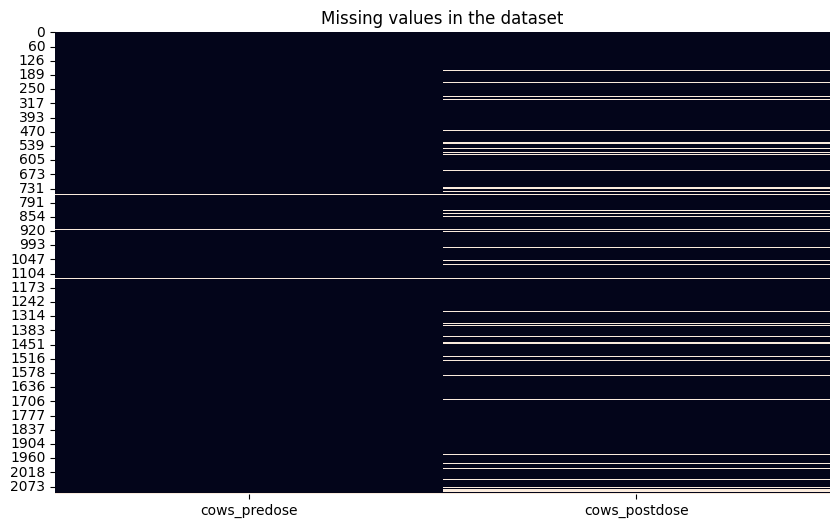

In [31]:
# create heatmap for cows_predose and cows_postdose
plt.figure(figsize=(10, 6))
sns.heatmap(new_df[['cows_predose', 'cows_postdose']].isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()


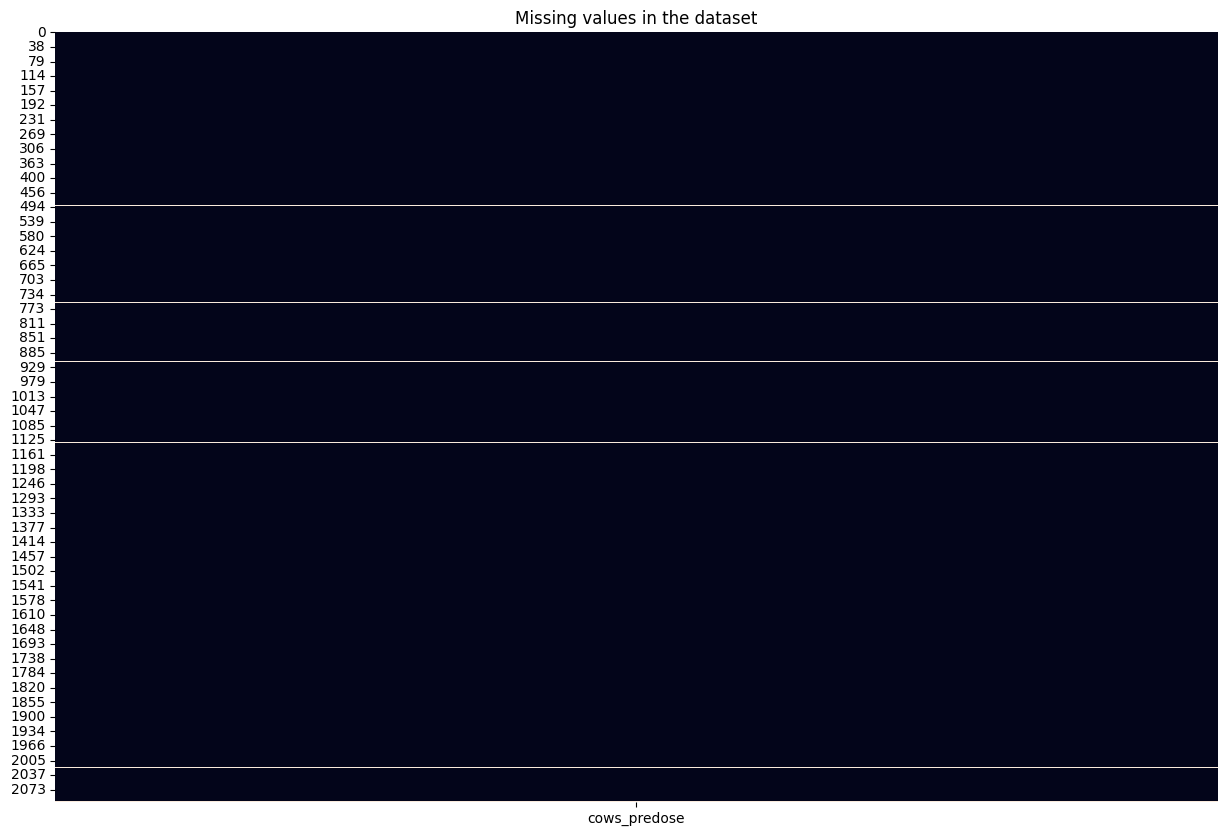

In [32]:
# create heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(new_df[['cows_predose']].isnull(), cbar=False, ax=ax)
plt.title('Missing values in the dataset')
plt.show()


### Observations from Missing Data
Given the healthcare context, the way in which missing data is handled is critical<br>
Removing rows with missing data, would create too much bias in the dataset<br>
We are also working with a small number of samples, it's important to preserve as much data as possible<br>
<br>
There are roughly 1,400 nan values that require strategy for imputation<br>
There are a few columns that show concern, listed as follows:<br>
- `medication` - there were 7 patient instances without data, we will inpute to 0 dose, for not attending<br>
but we will preserve their records as the data for their treatment is still valuable<br>
- `surveys` - there were 11 patient instances with missing surveys, 6 of these patient dropped out in week 1<br>
We will inpute with the mean value for surveys of that week, as the asumption is that the patient did used
drugs and did not submit a survey<br>
- `pex` - physical exam - there was 1 patient missing exam, we will inpute as not present
- `dsm` - addiction diagnosis - there were 4 patients missing addiction diagnosis, we will inpute as not evaluated
-`rbs` - risk based survey, there were 3 patients missing this survey, we will inpute with mean value for the assessment


The clinical opiate withdrawal scale has a high number of missing values<br>
- `cows_predose` - 33
- `cows_postdose` - 171 


### Evaluate Patient Nulls for Surveys

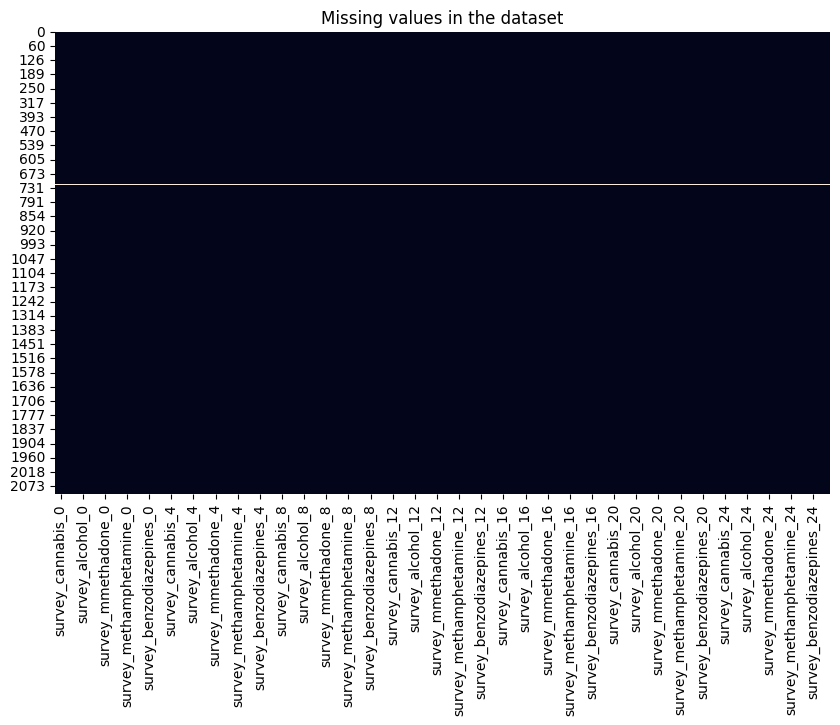

In [33]:
# create survey df to evaluate nulls
survey = new_df[[col for col in new_df.columns if 'survey' in col]]


# heatmap for survey nulls
plt.figure(figsize=(10, 6))
sns.heatmap(survey.isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()


### Evaluate Patient Nulls for Medication

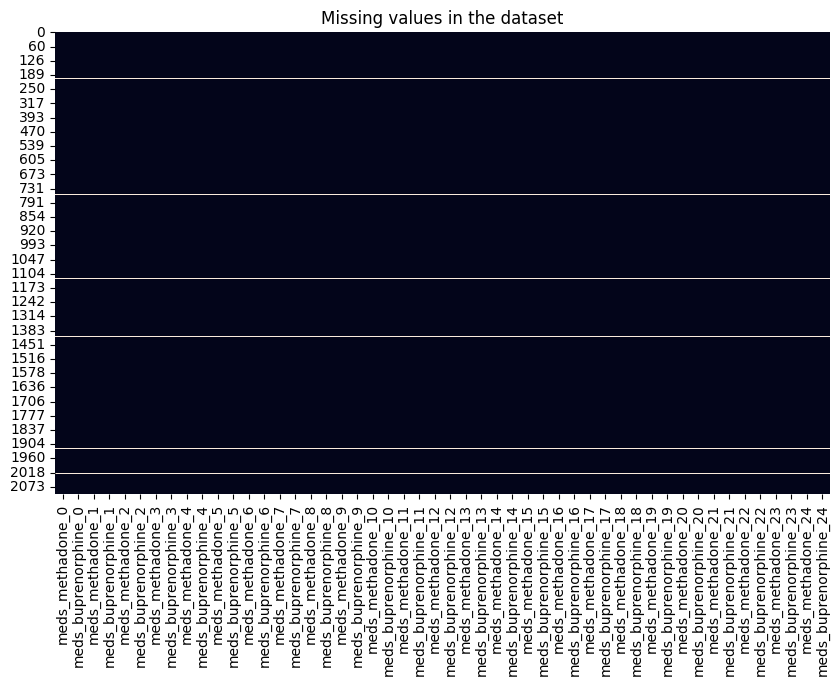

In [34]:
# create meds DF to evaluate nulls
meds = new_df[[col for col in new_df.columns if 'meds' in col]]

# heatmap for meds nulls
plt.figure(figsize=(10, 6))
sns.heatmap(meds.isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()

### Evaluate Patient Nulls for Medication

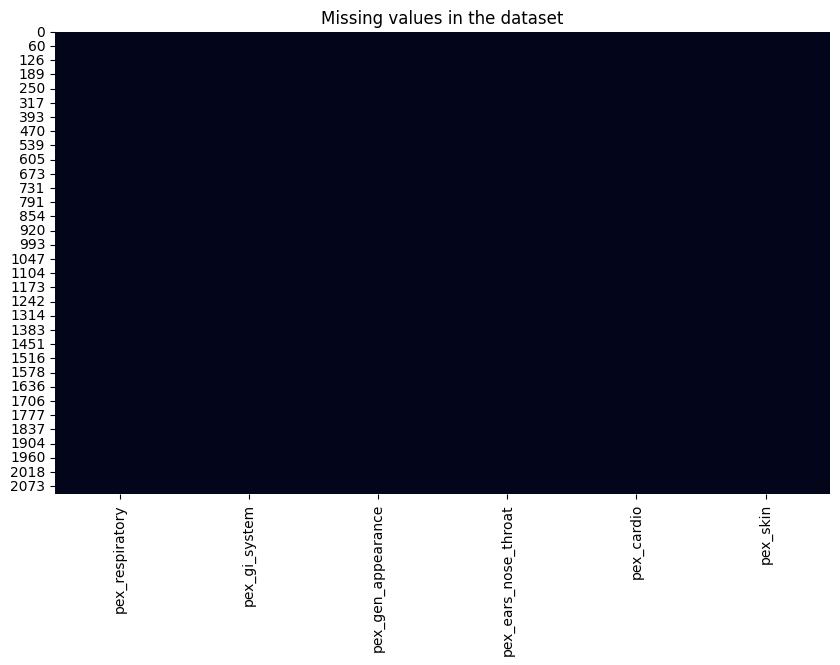

In [35]:
pex = new_df[[col for col in new_df.columns if 'pex' in col]]

# heatmap for pex nulls
plt.figure(figsize=(10, 6))
sns.heatmap(pex.isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()


### Evaluate Patient Nulls for Physical Exam

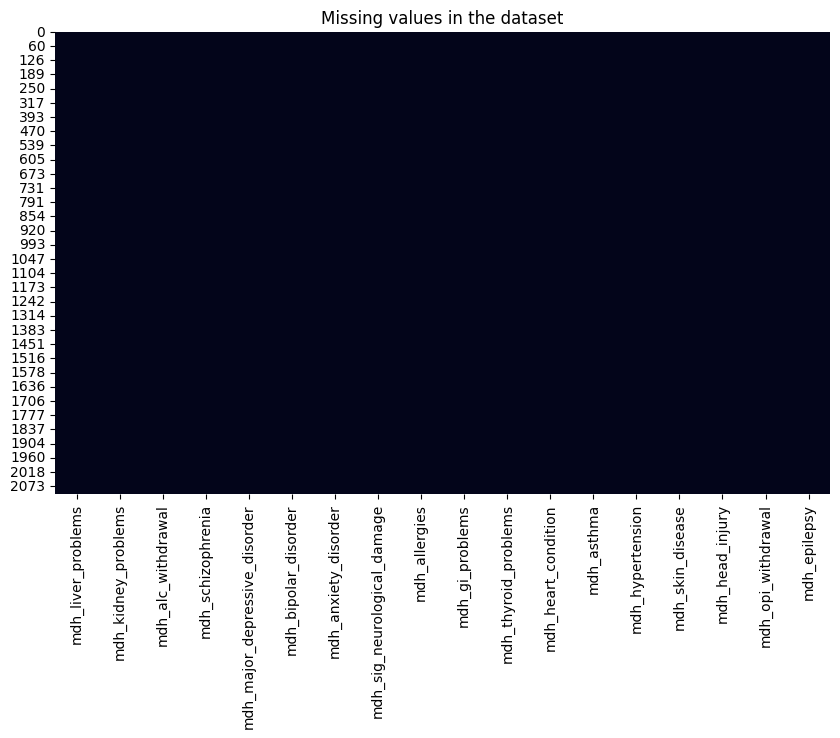

In [36]:
mdh = new_df[[col for col in new_df.columns if 'mdh' in col]]

# heatmap for mdh nulls
plt.figure(figsize=(10, 6))
sns.heatmap(mdh.isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()


### Evaluate Patient Nulls for DSM Diagnosis  

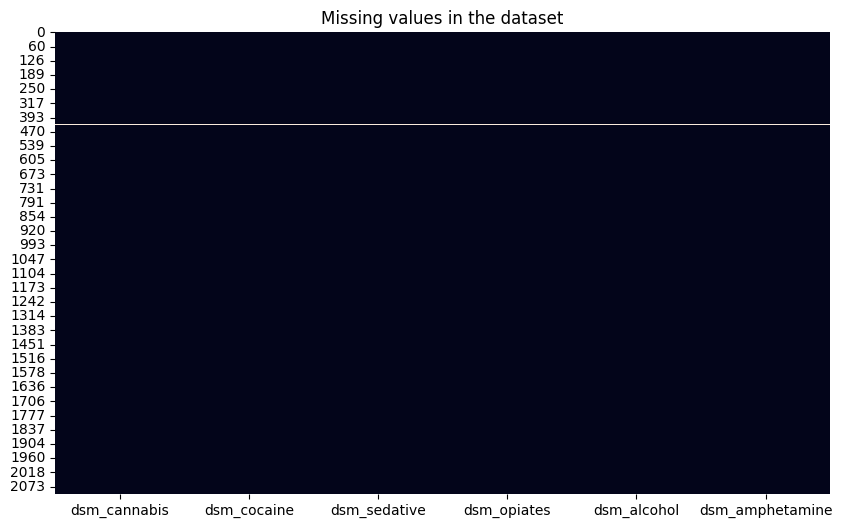

In [37]:
dsm = new_df[[col for col in new_df.columns if 'dsm' in col]]

# heatmap for dsm nulls
plt.figure(figsize=(10, 6))
sns.heatmap(dsm.isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()


### Evaluate RBS Nulls

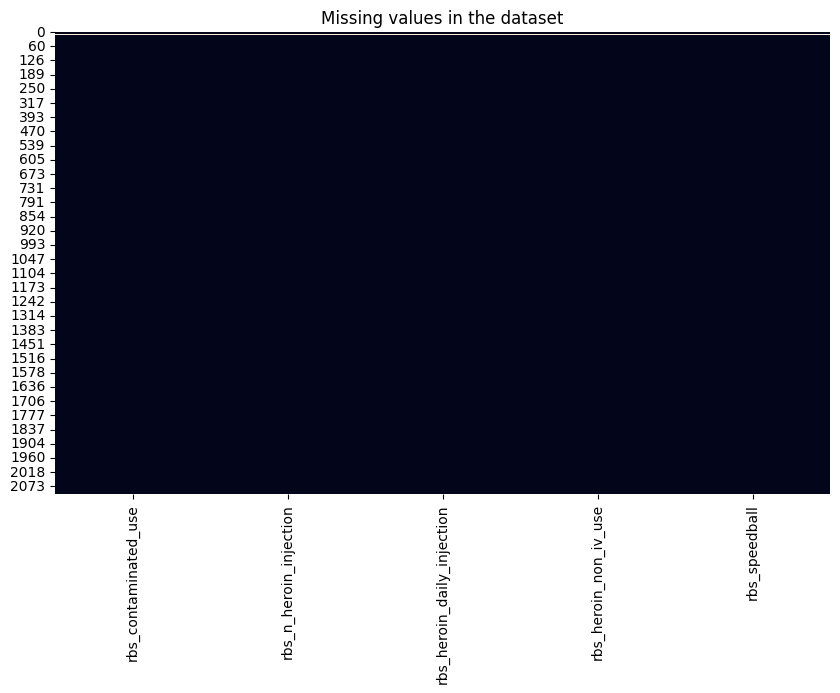

In [38]:
rbs = new_df[[col for col in new_df.columns if 'rbs' in col]]

# heatmap for rbs nulls
plt.figure(figsize=(10, 6))
sns.heatmap(rbs.isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()

## Impute COWS columns with iterative imputer

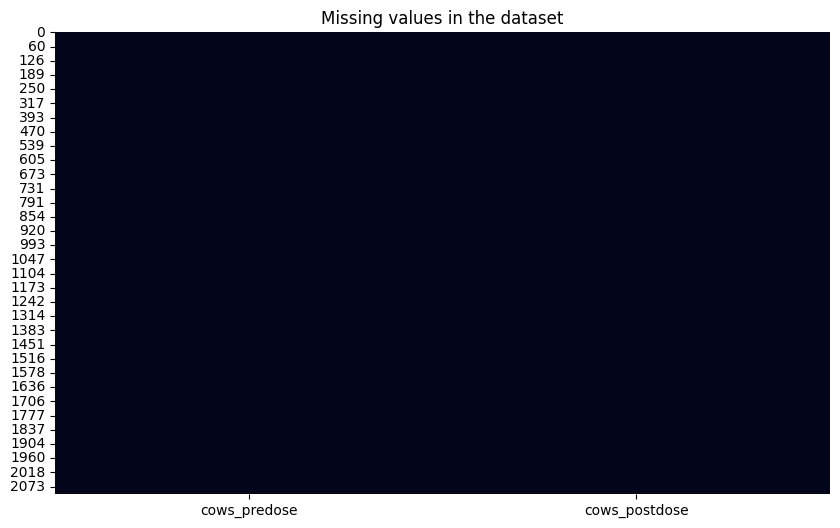

In [39]:
# inpute cows columns with iterative inputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# create imputer object
imputer = IterativeImputer(max_iter=10, random_state=0)

# fit the imputer
imputer.fit(new_df[['cows_predose', 'cows_postdose']])
new_df[['cows_predose', 'cows_postdose']] = imputer.transform(new_df[['cows_predose', 'cows_postdose']])

# check for nulls with heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(new_df[['cows_predose', 'cows_postdose']].isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()



## Impute RBS cols with iterative imputer

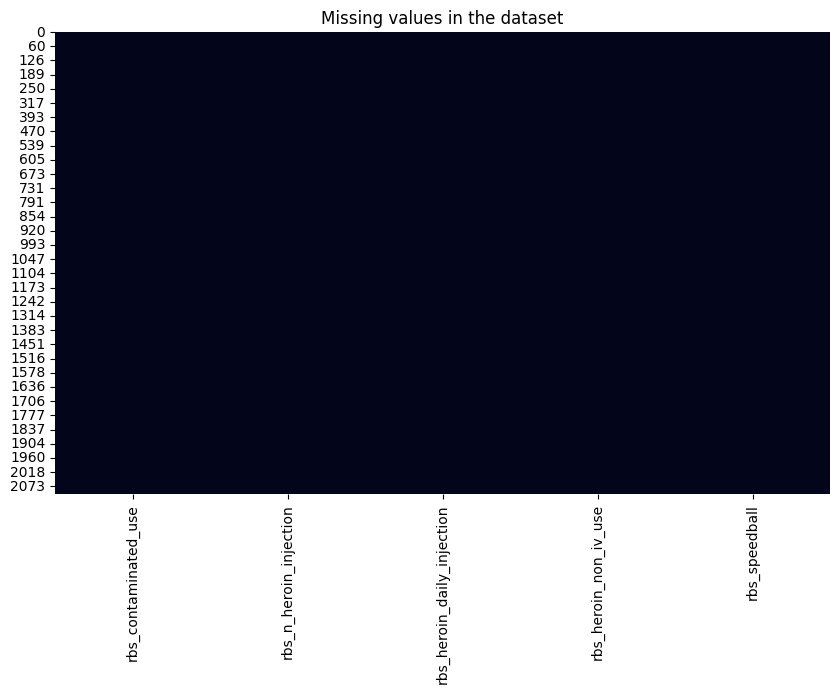

In [40]:
# inpute cols with 'rbs' use list comprehension to call cols
cols = [col for col in new_df.columns if 'rbs' in col]

# fit the imputer
imputer.fit(new_df[cols])

# transform the data
new_df[cols] = imputer.transform(new_df[cols])

# check for nulls with heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(new_df[cols].isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()


# inpute cols with 

### Imputation Execution
- `medication` - 7 instances inpute with 0 dose
- `surveys` - 11 instances inpute with mean value for that week
- `pex` Physical Exam - 1 instance inpute as not present
- `dsm` Addiction diagnosis - 4 instances inpute as not evaluated
- `cows_predose` - 33 instances, we will inpute with linear regression
- `cows_postdose` - 171 instances, we will inpute with linear regression



In [41]:
# run a loop to fill nulls with simple replacement
for col in new_df.columns:
    if 'meds' in col:
        new_df[col] = new_df[col].fillna(0)
    elif 'medication':
        new_df[col] = new_df[col].fillna(0)
    elif 'survey' in col:
        new_df[col] = new_df[col].fillna(0)
    elif 'pex' in col:
        new_df[col] = new_df[col].fillna(0)
    elif 'mdh' in col:
        new_df[col] = new_df[col].fillna('not_evaluated')
    elif 'dsm' in col:
        new_df[col] = new_df[col].fillna('not_evaluated')
    


## Last Visual Check for Missing Data

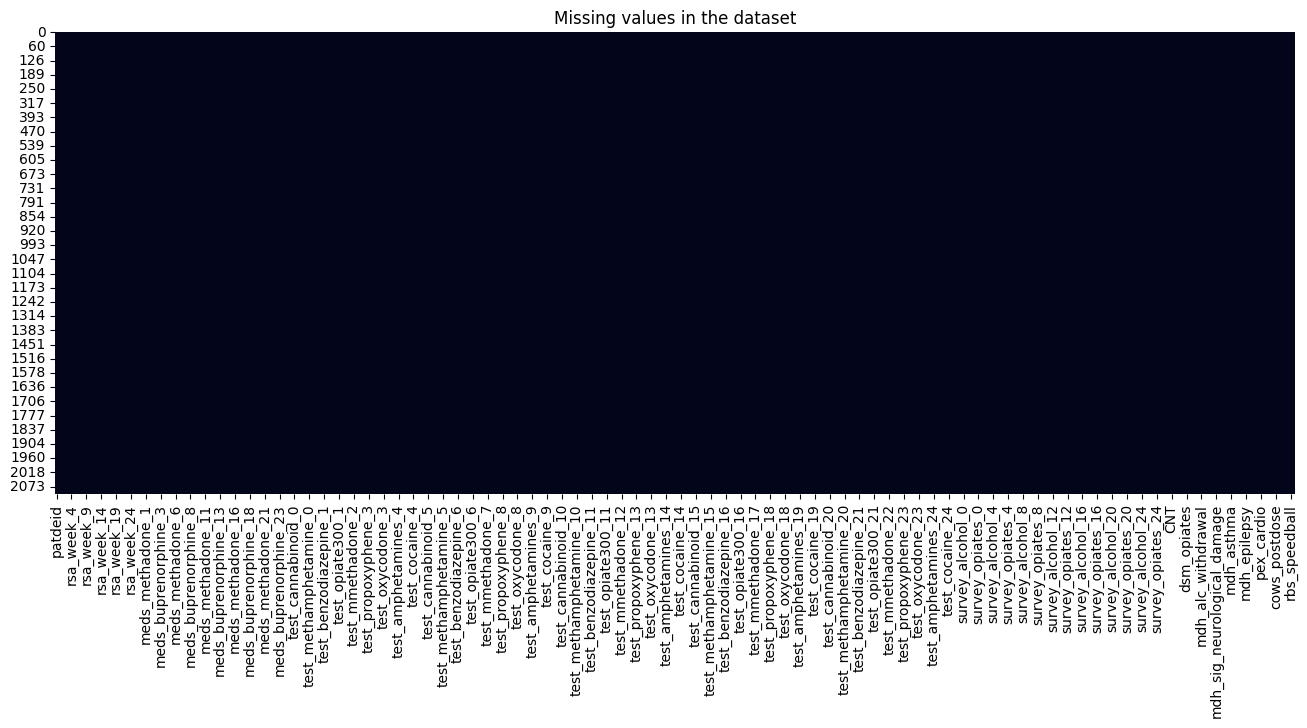

In [42]:
# heatmap for nulls
plt.figure(figsize=(16, 6))
sns.heatmap(new_df.isnull(), cbar=False)
plt.title('Missing values in the dataset')
plt.show()


In [43]:
# change columns with cows to int
new_df[['cows_predose','cows_postdose']] = new_df[['cows_predose','cows_postdose']].astype(int)

In [44]:
# save to data folder in csv
new_df.to_csv('../data/final_merged_data.csv', index=False)